In [59]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd

# read graph data from a JSON file
with open("ARC_with_single_GLC.json", "r") as f:
    graph_data = json.load(f)

model, duration = pathview.make_pathsim_model(graph_data)

model.run(0.1 * 24 * 3600)


18:12:45 - INFO - LOGGING (log: True)
18:12:45 - INFO - BLOCKS (total: 39, dynamic: 10, static: 29, eventful: 1)
18:12:45 - INFO - GRAPH (nodes: 39, edges: 57, alg. depth: 6, loop depth: 0, runtime: 0.106ms)
18:12:45 - INFO - STARTING -> TRANSIENT (Duration: 8640.00s)
18:12:45 - INFO - --------------------   3% | 0.2s<3.1s | 31.7 it/s
18:12:45 - INFO - ####----------------  20% | 0.4s<1.3s | 29.1 it/s
18:12:45 - INFO - ########------------  41% | 0.8s<1.0s | 26.5 it/s
18:12:46 - INFO - ############--------  60% | 1.1s<0.8s | 26.5 it/s
18:12:46 - INFO - ################----  81% | 1.8s<0.4s | 26.7 it/s
18:12:47 - INFO - #################### 100% | 2.3s<--:-- | 27.4 it/s
18:12:47 - INFO - FINISHED -> TRANSIENT (total steps: 62, successful: 54, runtime: 2280.27 ms)


{'total_steps': 62, 'successful_steps': 54, 'runtime_ms': 2280.273586000476}

Available scopes:
0: 15
1: 16
2: 50
3: 30
4: 51
5: 52
OFCScope labels: ['blanket (inv)', 'HX (inv)', 'FW (inv)', 'Divertor (inv)', 'T seperation membrane (inv)']
IFCScope labels: ['storage (inv)', 'pump (inv)', 'fuel cleanup (inv)', 'ISS (inv)']
efficiency labels: ['BCR 1 (eff)']
liquid concentration labels: ['BCR 1 (y_T2_out)', 'y_T2_in']
gas concentration labels: ['BCR 1 (c_T_out)', 'c_T_in [mol/m3]']


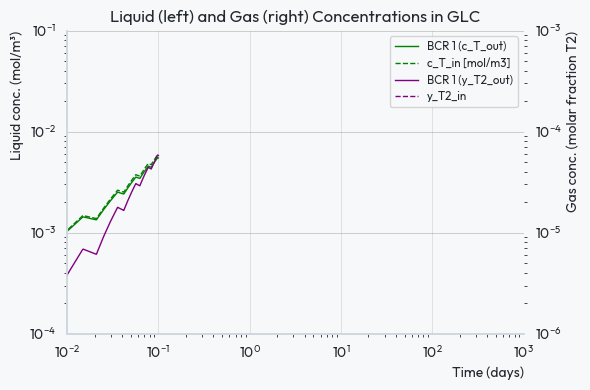

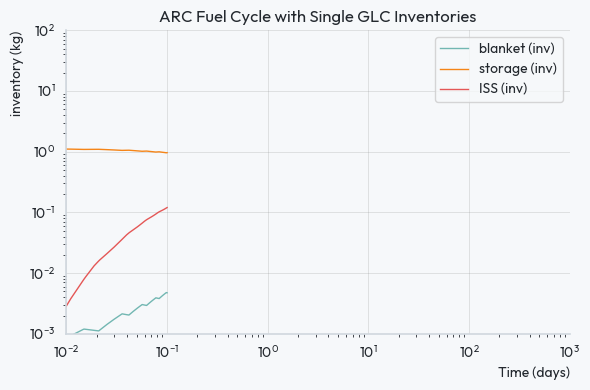

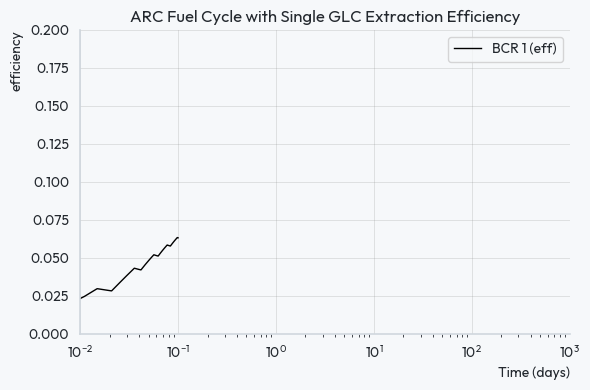

In [63]:
import morethemes as mt
mt.set_theme("lighter")

scopes = [block for block in model.blocks if isinstance(block, Scope)]

print("Available scopes:")
for i, scope in enumerate(scopes):
    print(f"{i}: {scope.id}")

ifc_scope = scopes[1]
ofc_scope = scopes[0]
fusion_rate_scope = scopes[3]
efficiency_scope = scopes[2]
liquid_concentration_scope = scopes[4]
gas_concentration_scope = scopes[5]

print("OFCScope labels:", ofc_scope.labels)
print("IFCScope labels:", ifc_scope.labels)
print("efficiency labels:", efficiency_scope.labels)
print("liquid concentration labels:", liquid_concentration_scope.labels)
print("gas concentration labels:", gas_concentration_scope.labels)

# Plot inventories
plt.subplots(figsize=(6, 4))
plt.title("ARC Fuel Cycle with Single GLC Inventories")

for scope in [ofc_scope, ifc_scope]:
    sim_time, data = scope.read()
    for p, d in enumerate(data):
        lb = scope.labels[p] if p < len(scope.labels) else f"port {p}"
        if any([kw in lb.lower() for kw in ["blanket", "iss", "storage"]]):
            l, = plt.plot(sim_time / 3600 / 24, d, label=lb, linewidth=1)

            if "storage" in lb.lower():
                storage_colour = l.get_color()
            elif "blanket" in lb.lower():
                blanket_colour = l.get_color()

    plt.xlabel("Time (days)")
    plt.ylabel("inventory (kg)")
    plt.yscale("log")
    plt.xscale("log")
plt.ylim(1e-3, 1e2)
plt.xlim(1e-2, 1e3)

plt.legend()
plt.tight_layout()
plt.savefig("arc_single_GLC_inventories.pdf", dpi=300)
plt.show()

# Plot efficiency
plt.subplots(figsize=(6, 4))
plt.title("ARC Fuel Cycle with Single GLC Extraction Efficiency")

for scope in [efficiency_scope]:
    sim_time, data = scope.read()
    for p, d in enumerate(data):
        lb = scope.labels[p] if p < len(scope.labels) else f"port {p}"
        if any([kw in lb.lower() for kw in ["eff"]]):
            l, = plt.plot(sim_time / 3600 / 24, d, label=lb, color="black", linewidth=1)

    plt.xlabel("Time (days)")
    plt.ylabel("efficiency")
    plt.xscale("log")
plt.ylim(0, 0.2)
plt.xlim(1e-2, 1e3)

plt.legend()
plt.tight_layout()
plt.savefig("arc_single_GLC_efficiency.pdf", dpi=300)
plt.show()

# Plot concentrations
sim_time_liq, data_liq = liquid_concentration_scope.read()
sim_time_gas, data_gas = gas_concentration_scope.read()

fig2, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax1.set_title("Liquid (left) and Gas (right) Concentrations in GLC")
ax1.set_xlabel("Time (days)")
ax1.set_xscale("log")

# Plot liquid concentration data
for p, d in enumerate(data_liq):
    lb = liquid_concentration_scope.labels[p] if p < len(liquid_concentration_scope.labels) else f"port {p}"
    if any([kw in lb for kw in ["c_T_in [mol/m3]", "BCR 1 (c_T_out)"]]):
        ls = "--" if "_in" in lb.lower() else "-"
        ax1.plot(sim_time_liq / 3600 / 24, d, label=lb, linewidth=1, color = "green", linestyle=ls)

# Plot gas concentration data
for p, d in enumerate(data_gas):
    lb = gas_concentration_scope.labels[p] if p < len(gas_concentration_scope.labels) else f"port {p}"
    if any([kw in lb for kw in ["y_T2_in", "BCR 1 (y_T2_out)"]]):
        ls = "--" if "_in" in lb.lower() else "-"
        ax2.plot(sim_time_gas / 3600 / 24, d, label=lb, linewidth=1, color = "purple", linestyle=ls)


ax1.set_ylabel("Liquid conc. (mol/m³)")
ax2.set_ylabel("Gas conc. (molar fraction T2)")
ax1.set_yscale("log")
ax2.set_yscale("log")

# combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
if handles1 or handles2:
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="best", fontsize="small")

# optional fixed limits (remove or adjust if undesired)
ax1.set_xlim(1e-2, 1e3)
ax1.set_ylim(1e-4, 1e-1)   # liquid
ax2.set_ylim(1e-6, 1e-3)   # gas

fig2.tight_layout()
fig2.savefig("arc_single_GLC_concentrations.pdf", dpi=300)
fig2.show()

